In [1]:
#load gamelog_data
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import json
import requests
import datetime

def season_subset(df, year_season_start, year_season_end = None):
    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])
    if year_season_end is None:
        year_season_end = year_season_start + 1
    df_gt = df[df.GAME_DATE > datetime.date(year_season_start,9,1)]
    df_lt = df_gt[df_gt.GAME_DATE < datetime.date(year_season_end,9,1)]
    return df_lt.sort_values("GAME_DATE") if not df_lt.empty else None

In [ ]:
post85df = pd.read_csv('./gamelogs/master_post86df.csv')
post85df = post85df.drop('VIDEO_AVAILABLE',1)

In [1055]:
df85_15 = season_subset(post85df,1985,2015)

by_player = df85_15.groupby("PLAYER_NAME")

In [1056]:
df85_15["FANTASY_ZSCORE"] = by_player["FANTASY_PTS"].apply(lambda x: ((x - x.mean())/x.std()))
df85_15["i_ZSCORE_OVER"] = df85_15["FANTASY_ZSCORE"].map(lambda x: 1 if x > 1 else 0)
df85_15["SEASON_MIN"] = by_player['MIN'].apply(lambda x: x.map(lambda y: x.sum()))
df85_15["GAMES_PLAYED"] = by_player["PLAYER_NAME"].apply(lambda x: x.map(lambda y: len(x)))
for x in ['FG_PCT', 'FG3_PCT', 'FT_PCT']:
    df85_15[x] = df85_15[x].map(lambda y: 0 if np.isnan(y) else y)
df85_15["WL"] = [1 if v == "W" else 0 for v in df85_15.copy()["WL"]]

opp_home = df85_15.MATCHUP.map(lambda x: (x[-3:],0) if "@" in x else (x[-3:],1))
df85_15["OPP"] = opp_home.map(lambda x: x[0])
df85_15["i_HOME"] = opp_home.map(lambda x: x[1])

In [1057]:
#Add player bio data for age,weight,height
player_bios_df = pd.read_csv("./player_bios/player_bios.csv")
player_bios_df = player_bios_df.rename(columns = {'PERSON_ID': 'PLAYER_ID', 'DISPLAY_FIRST_LAST': 'PLAYER_NAME'})
player_bios_df["BIRTHDATE"] = pd.to_datetime(player_bios_df["BIRTHDATE"])
player_bios_df['AGE'] = player_bios_df["BIRTHDATE"].map(lambda x: round((pd.to_datetime('today') - x).days / 365.,2))
player_bios_df["WEIGHT"] = player_bios_df["WEIGHT"].astype('str')
player_bios_df["HEIGHT"] = player_bios_df["HEIGHT"].astype('str')
player_bios_df["WEIGHT"] = player_bios_df["WEIGHT"].map(lambda x:  float(x) if x != 'nan' else 0.)
player_bios_df["HEIGHT"] = player_bios_df["HEIGHT"].map(lambda x: (12.*float(x[0]) + float(x[2:])) if x != 'nan' else 0.)

by_player = df85_15.groupby("PLAYER_NAME")

In [1058]:
def get_player_bio(name, col_name):
    return float(player_bios_df[player_bios_df.PLAYER_NAME == name][col_name])

df85_15["AGE"] = by_player["PLAYER_NAME"].apply(lambda x: x.replace(x.iloc[0],get_player_bio(x.iloc[0],"AGE")))
df85_15["WEIGHT"] = by_player["PLAYER_NAME"].apply(lambda x: x.replace(x.iloc[0],get_player_bio(x.iloc[0],"WEIGHT")))
df85_15["HEIGHT"] = by_player["PLAYER_NAME"].apply(lambda x: x.replace(x.iloc[0],get_player_bio(x.iloc[0],"HEIGHT")))

In [1059]:
#Integrate ELO Rankings
elo_df = pd.read_csv("./gamelogs/all_elo.csv")
elo_df["date_game"] = pd.to_datetime(elo_df["date_game"])
elo_df["game_location"] = elo_df["game_location"].map(lambda x: 1 if x == "H" else 0)
elo_df = elo_df[elo_df["is_playoffs"] == 0]

curr = elo_df.columns.tolist()
cols = [curr[i] for i in [5,8,11,13,14,17,19,21]]
elo_df = elo_df[cols]
elo_df = elo_df.rename(columns={'date_game': 'GAME_DATE',
                                'team_id':'TEAM_ABBREVIATION',
                                'opp_id':'OPP', 
                                'game_location': 'i_HOME',
                                'elo_i':'ELO',
                                'opp_elo_i': 'OPP_ELO',
                                'win_equiv': 'EXP_WINS',
                                'forecast':'FORECAST'})

elo_df['SHIT'] = elo_df['OPP_ELO'].map(lambda x: 1 if x < 1400 else 0)
elo_df['OKAY'] = elo_df['OPP_ELO'].map(lambda x: 1 if 1400 <= x < 1600 else 0)
elo_df['GOOD'] = elo_df['OPP_ELO'].map(lambda x: 1 if 1600 <= x < 1700 else 0)
elo_df['GREAT'] = elo_df['OPP_ELO'].map(lambda x: 1 if 1700 <= x else 0)

df85_15 = df85_15.merge(season_subset(elo_df,1985,2015))

In [1069]:
#Rearrange some columns in df85_15
curr = df85_15.columns.tolist()
cols = curr[:3] + curr[32:37] + curr[3:9] + curr[37:] + curr[9:32]
if len(curr) == len(cols):
    df85_15 = df85_15[cols]


name_pos = player_bios_df[["PLAYER_ID","POSITION","PLAYER_NAME"]]
df85_15 = df85_15.merge(name_pos)
df85_15["POSITION"] = df85_15.POSITION.map(lambda x: "Unknown" if pd.isnull(x) else x)
df85_15.columns.tolist()

['SEASON_ID',
 'PLAYER_ID',
 'PLAYER_NAME',
 'SEASON_MIN',
 'GAMES_PLAYED',
 'OPP',
 'i_HOME',
 'AGE',
 'TEAM_ABBREVIATION',
 'TEAM_NAME',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP',
 'WL',
 'WEIGHT',
 'HEIGHT',
 'ELO',
 'EXP_WINS',
 'OPP_ELO',
 'FORECAST',
 'SHIT',
 'OKAY',
 'GOOD',
 'GREAT',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'PLUS_MINUS',
 'FANTASY_PTS',
 'FANTASY_ZSCORE',
 'i_ZSCORE_OVER',
 'POSITION']

In [8]:
def calc_season_avg(df,col_list,(date_str1,date_str2)):
    date1, date2 = pd.to_datetime(date_str1), pd.to_datetime(date_str2)
    mask = lambda x: (date1 <= x) & (x <= date2)
    return df[df.GAME_DATE.apply(mask)].groupby(["PLAYER_NAME","SEASON_ID"])[col_list].mean().reset_index()

In [9]:
def ngames_colname(col_list, ngames):
    return map(lambda x: str(ngames) + 'D_' + x, col_list)

In [10]:
def last_ngames(df,ngames,game_date,col_list):
    ngames_df = df[df.GAME_DATE < game_date].nlargest(ngames, "GAME_DATE")
    ngames_col_list = ngames_colname(col_list,ngames)
    num_cols = len(ngames_col_list)
    date_player_tuples = [("GAME_DATE",game_date)]#,("PLAYER_NAME",df.PLAYER_NAME.iloc[0])]
    if ngames_df.empty:
        return dict(date_player_tuples + zip(ngames_col_list,np.array(0).repeat(num_cols)))
    else:
        return dict(date_player_tuples + zip(ngames_col_list,ngames_df[col_list].mean()))

In [11]:
def calc_ngame_avg(df,col_list,game_date_str,ngames):
    game_date = pd.to_datetime(game_date_str)
    season_id = df[df.GAME_DATE == game_date]["SEASON_ID"].iloc[0]
    return last_ngames(df[df.SEASON_ID == season_id],ngames,game_date,col_list)

In [12]:
def rolling_cols(df,col_list,ngames,rolling_kind):
    if rolling_kind == 'mean':
        rolling_func = lambda (a,b,c): pd.rolling_mean(a,b,min_periods = c)
    elif rolling_kind == 'sum':
        rolling_func = lambda (a,b,c): pd.rolling_sum(a,b,min_periods = c)
    else:
        return None 
    
    rolling_df = (df.groupby(["PLAYER_NAME","SEASON_ID"])
                    .apply(lambda x: add_game_date_pts_col(rolling_func((x[col_list],ngames,1)),x.GAME_DATE,x.FANTASY_PTS).reset_index(drop = True)))
    return rolling_df.reset_index().drop('level_2',axis = 1).rename(columns=dict(zip(col_list,map(lambda x: 'R_' + x,col_list))))

In [13]:
def add_game_date_pts_col(df,game_date_col,fantasy_pts_col):
   new_df = pd.concat([df,game_date_col], axis = 1)
   return new_df

In [14]:
def per_season_cumsum(df,col_list):
    cumsum_df = (df.groupby(["PLAYER_NAME","SEASON_ID"])
                   .apply(lambda x: add_game_date_col(x[col_list].cumsum(axis = 0), x.GAME_DATE).reset_index(drop = True)))
    return cumsum_df.reset_index().drop('level_2',axis = 1).rename(columns=dict(zip(col_list,map(lambda x: 'C_' + x,col_list))))

In [15]:
def per_season_cummean(df,col_list):
    cumsum_df = (df.groupby(["PLAYER_NAME","SEASON_ID"])
                   .apply(lambda x: add_game_date_pts_col(pd.expanding_mean(x[col_list], min_periods = 2), x.GAME_DATE, x.FANTASY_PTS).reset_index(drop = True)))
    return cumsum_df.reset_index().drop('level_2',axis = 1).rename(columns=dict(zip(col_list,map(lambda x: 'C_' + x,col_list))))

In [16]:
def enumerate_games(df):
    new_df = df.copy()
    new_df["GAME_NUM"] = range(1,len(df.GAME_DATE) + 1)
    return new_df

def sigmoidfun(x):
	return 1/(1+np.exp(-0.007*(x-800)))

def fantasy_avg_lastn(player_df,last_n_seasons,seasons):
    return player_df[[s in seasons[-last_n_seasons:] for s in player_df.SEASON_ID]]['FANTASY_PTS'].mean()    

def true_fantasy_mean(player_df,last_n_seasons):
    seasons = list(set(player_df.SEASON_ID))
    lastn_mean = fantasy_avg_lastn(player_df,last_n_seasons,seasons)
    return player_df.groupby("SEASON_ID").apply(lambda x: x.apply(lambda y: lastn_mean + sigmoidfun(y.MIN) * (y.C_FANTASY_PTS - lastn_mean),axis = 1))

def fantasy_resp(df):
    return df.groupby('PLAYER_NAME').apply(lambda x: true_fantasy_mean(x,5))

In [976]:
df[~mask]

,SEASON_ID,PLAYER_ID,PLAYER_NAME,SEASON_MIN,GAMES_PLAYED,OPP,i_HOME,AGE,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,WEIGHT,HEIGHT,ELO,EXP_WINS,OPP_ELO,FORECAST,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,FANTASY_ZSCORE,i_ZSCORE_OVER,POSITION,EWMA_OPP_POS,SHIT,OKAY,GOOD,GREAT,EWMA_LOG_FANTASY_PTS,FANTASY_PTS_RESP
929,22010,1717,Dirk Nowitzki,44927,1265,LAL,1,37.49,DAL,Dallas Mavericks,21000982,2011-03-12,DAL vs. LAL,0,245,84,1656.3761,55.39402,1666.0109,0.627191,37,10,19,0.526,0,2,0,5,5,1,1,9,10,6,1,2,2,3,25,1,51.5,0.965753,0,Forward,4.140771,0,0,1,0,3.672273,1


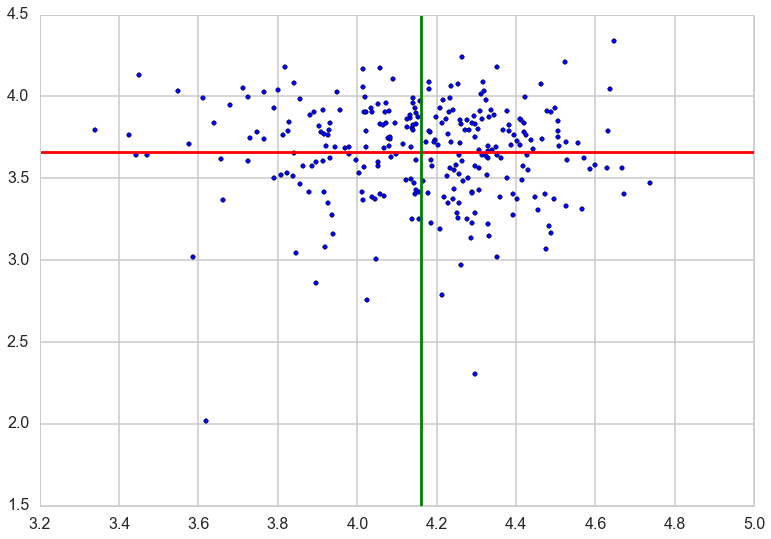

In [955]:
plt.scatter(df.EWMA_OPP_POS,np.log(df.FANTASY_PTS + 1))
plt.axhline(np.log(df.FANTASY_PTS + 1).mean(), color ='red')
plt.axvline(df.EWMA_OPP_POS.mean(), color ='green')

In [956]:
;

''

In [977]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
#train_test_split(xrange(df.shape[0]), train_size=0.7)

dftouse = df.copy()

ewma_feats = map(lambda x: 'EWMA_LOG_' + x , ewma_colfeats)
STANDARDIZABLE = ['EWMA_LOG_' + ewma_colresp, 'EWMA_OPP_POS'] + ewma_feats
for col in STANDARDIZABLE:
    print col
    valstrain=df[col].values[mask]
    valstest=df[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse[col]=out

lcols = STANDARDIZABLE + ["OKAY","GOOD","GREAT"]


clfsvm = LinearSVC(C=.01)
#cs=[.0001,.001,.01,.1,1,10]
#n_estimators = [1,2,10,100,500,1000]
#max_depth = [2,3,5,7,10]
pca = PCA(n_components=2)
feats = list(set(lcols) - set(['OKAY','GOOD','GREAT']))


Xmatrix=pca.fit_transform(np.array(dftouse[feats]))
Yresp=dftouse[ewma_colresp + '_RESP'].values 
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

#your code here
# from sklearn.grid_search import GridSearchCV
# #{'n_estimators':n_estimators,'max_depth':max_depth}
# gs=GridSearchCV(clfsvm, param_grid={'C':cs}, cv=5)
# gs.fit(Xmatrix_train, Yresp_train)
# print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

# #calculate the accuracy here
# best = gs.best_estimator_
# best.fit(Xmatrix_train, Yresp_train)
# best.score(Xmatrix_test, Yresp_test)
print(pca.explained_variance_ratio_)
print feats
clfsvm.fit(Xmatrix_train, Yresp_train)
clfsvm.score(Xmatrix_test, Yresp_test)

EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
[ 0.5290442  0.4709558]
['EWMA_LOG_FANTASY_PTS', 'EWMA_OPP_POS']


0.0

In [938]:
dftouse[~mask][clfsvm.predict(Xmatrix_test) == 1]['FANTASY_PTS_RESP'].mean()

0.4594594594594595

[5, 4, 3, 2, 1]

In [263]:
merged_df = pd.merge(df85_15,df85_15.groupby(["PLAYER_NAME",'OPP']).apply(lambda x: x.FANTASY_PTS).reset_index().rename(columns = {0:"FANTASY_PTS_AGAINST"}), left_on=['PLAYER_NAME','OPP'],right_on=['PLAYER_NAME','OPP'])

In [17]:
merged_df = pd.merge(df85_15,per_season_cummean(df85_15,['FANTASY_PTS']))

In [19]:
true_mean_df = merged_df.groupby(['PLAYER_NAME','SEASON_ID']).apply(lambda x: x.apply(lambda y: fantasy_avg_lastn(x,5,list(set(x.SEASON_ID))) + sigmoidfun(y.MIN) * (y.C_FANTASY_PTS - fantasy_avg_lastn(x,5,list(set(x.SEASON_ID)))), axis = 1))

TypeError: unhashable type: 'list'

In [20]:
merged_true_mean = pd.merge(df85_15,true_mean_df.reset_index().set_index('level_2'))

In [21]:
merged_true_mean = merged_true_mean.rename(columns={0:'TRUE_FANTASY_AVG'})

In [ ]:
true_mean_df85_15 = true_mean_df.reset_index().rename(columns={0:'TRUE_FANTASY_AVG'}).set_index('level_2')
del true_mean_df85_15.index.name

In [35]:
true_mean_df85_15.to_csv('./true_mean_df85_152.csv', index = False)

In [27]:
df85_15.shape

(550709, 44)

In [49]:
check_df = pd.read_csv('./true_mean_df85_152.csv')

In [1337]:
test_df = season_subset(df85_15,2006,2010)
kobe_df = test_df[test_df.PLAYER_NAME == "Rajon Rondo"]
kobe_df = kobe_df.groupby("SEASON_ID").apply(lambda x: enumerate_games(x).reset_index(drop = True)).reset_index(drop = True)

(0, 80)

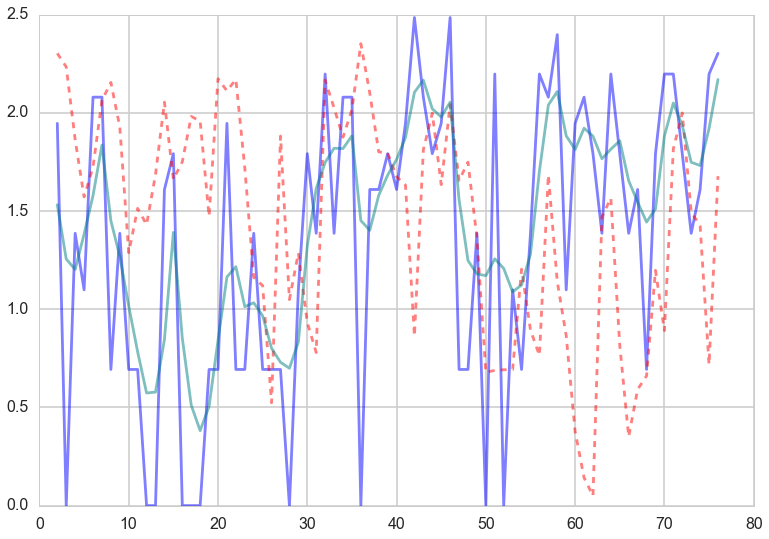

In [1339]:
fig = plt.figure()
ax = plt.axes()
season = map(lambda x: 20000 + x, [2006,2007,2008,2009])
fwd = np.log(pd.ewma(kobe_df[kobe_df.SEASON_ID == season[0]]['AST'], span = 2, adjust = False).shift(1) + 1)[1:]
bwd = np.log(pd.ewma(kobe_df[kobe_df.SEASON_ID == season[0]]['AST'][::-1], span = 2, adjust = False).shift(1) + 1)[1:]
c = np.vstack((fwd,bwd[::-1])).mean(axis = 0)
ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'][1:], np.log(kobe_df[kobe_df.SEASON_ID == season[0]]['AST'] + 1)[1:], linestyle='-', color ='b', alpha = 0.5)
ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'][1:], bwd, linestyle='--', color ='r', alpha = 0.5)
#ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'][1:], np.log(pd.ewma(kobe_df[kobe_df.SEASON_ID == season[0]]['AST'][::-1], span = 2, adjust = False).shift(1)), linestyle='-', color ='teal', alpha = 0.5)
ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'][1:], c, linestyle='-', color ='teal', alpha = 0.5)
#ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'], np.log(pd.expanding_mean(kobe_df[kobe_df.SEASON_ID == season[0]]['AST']).shift(1)), linestyle=':', color ='g', alpha = 0.5)

#ax.plot(kobe_df[kobe_df.SEASON_ID == season[3]]['GAME_NUM'], np.log(kobe_df[kobe_df.SEASON_ID == season[3]]['PTS']), linestyle='-.', color ='k', alpha = 0.5)
ax.set_xlim(min(kobe_df['GAME_NUM']) - 1, max(kobe_df['GAME_NUM']) + 1)


In [73]:
ewma_pos = test_df.groupby(["OPP",'SEASON_ID',"POSITION"]).apply(lambda x: np.log(pd.ewma(x.PTS,span = 3).shift(1))).reset_index().rename(columns={'PTS':'EWMA_OPP_POS', 'level_3':'OLD_INDEX'}).set_index('OLD_INDEX')
cols_touse = ewma_pos.columns.difference(test_df.columns)
pd.merge(test_df,ewma_pos[cols_touse], left_index = True, right_index = True, how = 'outer')

In [327]:
days_rest = (df85_15.groupby('PLAYER_NAME')
    .apply(lambda x: pd.Series([float('nan')] + map(lambda y: (x.loc[x.index.tolist()[y+1]].GAME_DATE - x.loc[x.index.tolist()[y]].GAME_DATE).days - 1,range(x.shape[0] - 1)), index = x.index)))

In [329]:
days_rest = days_rest.reset_index(level = 0).rename(columns={0:'DAYS_REST'})

In [332]:
days_rest_df = pd.merge(df85_15, days_rest.drop('PLAYER_NAME', axis = 1), left_index = True, right_index=True)

In [334]:
days_rest_df.to_csv('./gamelogs/days_rest_df.csv', index = False)

In [340]:
store_df = []
for season in ['2' + str(year) for year in range(1996,2016)]:
    store_df.append(pd.read_csv('./defense_stats/' + season + '.csv'))
defense_df = pd.concat(store_df, axis = 0)
del store_df

In [1079]:
;

''

In [407]:
team_abbr_df = days_rest_df.groupby("TEAM_NAME").apply(lambda x: x.TEAM_ABBREVIATION.values[0]).reset_index().rename(columns={0:'TEAM_ABBR'})

In [410]:
defense_df['TEAM_ABBR'] = defense_df.TEAM_NAME.map(lambda x: team_abbr_df[team_abbr_df.TEAM_NAME == x]['TEAM_ABBR'].values)

In [409]:
team_abbr_df[team_abbr_df.TEAM_NAME == "Boston Celtics"]['TEAM_ABBR']

1    BOS
Name: TEAM_ABBR, dtype: object

In [1078]:
;

''

In [389]:
list(set(days_rest_df[days_rest_df.PLAYER_NAME == "Steve Nash"]['TEAM_NAME']))

['Dallas Mavericks', 'Los Angeles Lakers']

In [ ]:
def calc_melo_TRUE_PER(x):
    TRUE_PER = ((x['PTS'].iloc[0])/(x['FGA'].iloc[0] + x['FTM'].iloc[0] * 0.44)) * 5
    return TRUE_PER

In [392]:
def calc_melo(x):
    MIN_PER = (x['SEASON_MIN'].iloc[0]/x['GAMES_PLAYED'].iloc[0]) * 3.5
    TRUE_PER = ((x['PTS'].iloc[0])/(x['FGA'].iloc[0] + x['FTM'].iloc[0] * 0.44)) * 5
    FT_FRQ = (x['FTA'].iloc[0]/x['FGA'].iloc[0]) * 1.5
    MELO_HT = x['HEIGHT'].iloc[0] * 3
    MELO_WT = x['WEIGHT'].iloc[0] * 1
    MELO_C_MIN = x['SEASON_MIN'].iloc[0] * 1.5
    MELO_FT_PER = x['FT_PCT'].iloc[0] * 2.5
    MELO_SCORE = MIN_PER + TRUE_PER + FT_FRQ + MELO_HT + MELO_WT + MELO_C_MIN + MELO_FT_PER
    return MELO_SCORE

['Washington Bullets',
 'Los Angeles Lakers',
 'Chicago Bulls',
 'New Jersey Nets',
 'Charlotte Bobcats',
 'San Antonio Spurs',
 'New Orleans Pelicans',
 'Philadelphia 76ers',
 'Detroit Pistons',
 'Boston Celtics',
 'Miami Heat',
 'Orlando Magic',
 'Portland Trail Blazers',
 'Golden State Warriors',
 'New York Knicks',
 'Washington Wizards',
 'Utah Jazz',
 'Dallas Mavericks',
 'Sacramento Kings',
 'New Orleans/Oklahoma City Hornets',
 'Los Angeles Clippers',
 'Vancouver Grizzlies',
 'Oklahoma City Thunder',
 'Charlotte Hornets',
 'Milwaukee Bucks',
 'Memphis Grizzlies',
 'Toronto Raptors',
 'Houston Rockets',
 'New Orleans Hornets',
 'Phoenix Suns',
 'Minnesota Timberwolves',
 'Seattle SuperSonics',
 'Cleveland Cavaliers',
 'Atlanta Hawks',
 'Brooklyn Nets',
 'Indiana Pacers',
 'Denver Nuggets']

In [1047]:
team_abbr_df;

In [398]:
store_df = []
for i in range(6):
    store_df.append(pd.read_csv('./DKSalaries/DKSalaries' + str(i) + '.csv'))
salary_df = pd.concat(store_df,axis = 0)
opt_players = list(set(salary_df.Name))
sampled_salary = salary_df.groupby("Name").apply(lambda x: x.sample(n=1)).reset_index(drop = True)
salary_dict = dict(zip(sampled_salary.Name, sampled_salary.Salary))
salary_dict

{'Aaron Gordon': 4100,
 'Aaron Harrison': 3000,
 'Adreian Payne': 3000,
 'Al Horford': 7000,
 'Al Jefferson': 6400,
 'Al-Farouq Aminu': 6200,
 'Alan Anderson': 3000,
 'Alec Burks': 5200,
 'Alex Len': 4300,
 'Alexis Ajinca': 3500,
 'Allen Crabbe': 3300,
 'Alonzo Gee': 3000,
 "Amar'e Stoudemire": 3000,
 'Amir Johnson': 4400,
 'Anderson Varejao': 3000,
 'Andre Drummond': 9900,
 'Andre Iguodala': 5200,
 'Andre Roberson': 3000,
 'Andrea Bargnani': 3000,
 'Andrew Bogut': 4900,
 'Andrew Nicholson': 3000,
 'Andrew Wiggins': 6900,
 'Andr\xc3\xa9 Miller': 3000,
 'Anthony Bennett': 3000,
 'Anthony Brown': 3000,
 'Anthony Davis': 10700,
 'Anthony Morrow': 3100,
 'Anthony Tolliver': 3000,
 'Archie Goodwin': 3000,
 'Aron Baynes': 3000,
 'Arron Afflalo': 4300,
 'Austin Rivers': 3600,
 'Avery Bradley': 5000,
 'Ben McLemore': 3600,
 'Beno Udrih': 3000,
 'Bismack Biyombo': 3800,
 'Blake Griffin': 9500,
 'Boban Marjanovic': 3000,
 'Bojan Bogdanovic': 3300,
 'Boris Diaw': 3400,
 'Bradley Beal': 6900,
 'Br

In [399]:
singleday = df85_15[[player in salary_dict.keys() for player in  df85_15.PLAYER_NAME]][df85_15.GAME_DATE == '2014-11-13']
#singleday
singleday['REAL_POSITION'] = singleday['POSITION'].map(lambda x: x.split("-")[0])
singleday.sort_values('FANTASY_PTS', ascending = False)
np.unique(singleday['REAL_POSITION'].values)
#PG = singleday[singleday.POSITION == '']

total_players = singleday['PLAYER_NAME'].values
forwards = singleday[[pos in ["Forward"] for pos in singleday['POSITION'].values]]['PLAYER_NAME'].values
guards = singleday[[pos in ["Guard"] for pos in singleday['POSITION'].values]]['PLAYER_NAME'].values
centers = singleday[[pos in ["Center"] for pos in singleday['POSITION'].values]]['PLAYER_NAME'].values

forward = list(np.random.choice(a=forwards,replace=False,size=3))
guard = list(np.random.choice(a=guards,replace=False,size=3))
center = list(np.random.choice(a=centers,replace=False,size=1))
util = np.random.choice(a=list(set(total_players) - set(forward + guard + center)), replace = False, size = 1)

//anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [400]:
np.unique(singleday['TEAM_ABBREVIATION'].values)

array(['DAL', 'MEM', 'PHI', 'SAC', 'TOR'], dtype=object)

In [401]:
gafantasypts = singleday['FANTASY_PTS'].values
gaforwards = singleday['REAL_POSITION'].map(lambda x: 1 if x == 'Forward' else 0).values
gaguards = singleday['REAL_POSITION'].map(lambda x: 1 if x == 'Guard' else 0).values
gacenters = singleday['REAL_POSITION'].map(lambda x: 1 if x == 'Center' else 0).values
#gautil = np.ones(len(gacenters))
gasalaries = singleday['PLAYER_NAME'].map(lambda x: salary_dict[x]).values

In [402]:
small_data = zip(gasalaries, gafantasypts, gaforwards, gaguards, gacenters)#,gautil)
small_data

[(6900, 30.75, 1, 0, 0),
 (3000, 24.0, 0, 1, 0),
 (3100, 19.25, 1, 0, 0),
 (6200, 30.0, 1, 0, 0),
 (4900, 23.5, 0, 0, 1),
 (3000, 3.5, 1, 0, 0),
 (3200, 15.5, 0, 1, 0),
 (3700, 13.5, 0, 1, 0),
 (3600, 11.5, 1, 0, 0),
 (3000, 4.75, 0, 1, 0),
 (4300, 8.75, 0, 1, 0),
 (3100, 13.0, 1, 0, 0),
 (6300, 33.5, 0, 1, 0),
 (4400, 25.75, 1, 0, 0),
 (7100, 41.25, 1, 0, 0),
 (8500, 42.5, 0, 1, 0),
 (3200, 0.0, 0, 0, 1),
 (3200, 26.25, 1, 0, 0),
 (6300, 41.75, 0, 1, 0),
 (3000, 15.0, 1, 0, 0),
 (3500, 8.75, 0, 1, 0),
 (3000, 17.75, 1, 0, 0),
 (7300, 38.75, 0, 0, 1),
 (3800, 10.75, 0, 0, 1),
 (3700, 27.75, 0, 1, 0),
 (4700, 2.0, 1, 0, 0),
 (7200, 16.25, 0, 1, 0),
 (4700, 33.5, 0, 1, 0),
 (3100, 39.25, 1, 0, 0),
 (3000, 2.5, 1, 0, 0),
 (6200, 16.5, 1, 0, 0),
 (10800, 45.5, 1, 0, 0),
 (3700, 10.5, 0, 1, 0),
 (3000, 5.0, 1, 0, 0),
 (3500, 8.25, 1, 0, 0),
 (3300, 11.25, 1, 0, 0),
 (4100, 27.0, 1, 0, 0),
 (5600, 14.0, 1, 0, 0),
 (5700, 22.0, 0, 0, 1),
 (3100, 23.25, 1, 0, 0),
 (4900, 17.5, 0, 1, 0),
 (5900

In [412]:
from pyeasyga import pyeasyga

ga = pyeasyga.GeneticAlgorithm(small_data)        # initialise the GA with data
ga.population_size = 200000
#ga.mutation_probability = 0.05
#ga.generations = 25

# define a fitness function
def fitness(individual, data):
    salaries, points, forwards, guards, centers = 0, 0, 0, 0, 0
    for (selected, item) in zip(individual, data):
        if selected:
            salaries += item[0]
            points += item[1]
            forwards += item[2]
            guards += item[3]
            centers += item[4]
    if salaries > 50000 or ((forwards > 4) and (guards > 4)) or ((guards > 4) and (centers > 2)) or ((forwards > 4) and (centers > 2)) or ((centers + gaurds + forwards) > 8):
        points = 0
    return points

ga.fitness_function = fitness               # set the GA's fitness function
ga.run()                                    # run the GA
print ga.best_individual()                  # print the GA's best solution

(304.0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


In [413]:
_,mask = ga.best_individual()
mask = np.array(mask) == 1
singleday[mask]

,SEASON_ID,PLAYER_ID,PLAYER_NAME,SEASON_MIN,GAMES_PLAYED,OPP,i_HOME,AGE,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,WEIGHT,HEIGHT,ELO,EXP_WINS,OPP_ELO,FORECAST,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,FANTASY_ZSCORE,i_ZSCORE_OVER,POSITION,REAL_POSITION
464568,22014,200752,Rudy Gay,23437,653,MEM,0,29.32,SAC,Sacramento Kings,21400118,2014-11-13,SAC @ MEM,0,230,80,1471.6376,37.417713,1615.1119,0.197570,40,8,17,0.471,1,2,0.500,8,8,1.000,3,4,7,2,1,1,0,3,25,10,41.25,0.757644,0,Forward,Forward
465108,22014,200768,Kyle Lowry,16977,576,CHI,1,29.72,TOR,Toronto Raptors,21400119,2014-11-13,TOR vs. CHI,0,205,72,1586.3180,48.181931,1560.5881,0.673434,34,8,19,0.421,3,7,0.429,1,3,0.333,1,7,8,8,0,0,2,5,20,-4,42.50,1.098549,1,Guard,Guard
480059,22014,201148,Brandan Wright,5917,360,PHI,1,28.19,DAL,Dallas Mavericks,21400120,2014-11-13,DAL vs. PHI,1,210,82,1589.8289,50.248981,1283.3352,0.912133,16,4,7,0.571,0,0,0.000,6,7,0.857,2,3,5,0,1,2,0,3,14,16,26.25,1.204679,1,Forward,Forward
480570,22014,201144,Mike Conley,18925,581,SAC,1,28.17,MEM,Memphis Grizzlies,21400118,2014-11-13,MEM vs. SAC,1,175,73,1615.1119,52.428242,1471.6376,0.802430,39,8,17,0.471,1,3,0.333,5,6,0.833,0,1,1,11,1,0,1,4,22,13,41.75,1.320188,1,Guard,Guard
506852,22014,201954,Darren Collison,12347,421,MEM,0,28.30,SAC,Sacramento Kings,21400118,2014-11-13,SAC @ MEM,0,175,72,1471.6376,37.417713,1615.1119,0.197570,37,6,11,0.545,2,3,0.667,6,7,0.857,0,2,2,5,1,1,3,2,20,8,33.50,0.782550,0,Guard,Guard
510267,22014,201949,James Johnson,6339,341,CHI,1,28.81,TOR,Toronto Raptors,21400119,2014-11-13,TOR vs. CHI,0,250,81,1586.3180,48.181931,1560.5881,0.673434,24,7,9,0.778,0,1,0.000,2,3,0.667,2,3,5,1,4,4,1,5,16,-1,39.25,2.146544,1,Forward,Forward
518600,22014,202326,DeMarcus Cousins,10859,350,MEM,0,25.33,SAC,Sacramento Kings,21400118,2014-11-13,SAC @ MEM,0,270,83,1471.6376,37.417713,1615.1119,0.197570,31,8,17,0.471,0,0,0.000,6,7,0.857,2,10,12,1,2,3,6,5,22,19,45.50,0.425667,0,Forward-Center,Forward
545188,22014,203487,Michael Carter-Williams,4565,136,DAL,0,24.17,PHI,Philadelphia 76ers,21400120,2014-11-13,PHI @ DAL,0,190,78,1283.3352,19.652514,1589.8289,0.087867,30,6,19,0.316,1,4,0.250,6,10,0.600,3,5,8,5,0,0,6,4,19,-37,34.00,-0.157379,0,Guard,Guard


In [683]:
%connect_info

{
  "stdin_port": 49217, 
  "ip": "127.0.0.1", 
  "control_port": 49218, 
  "hb_port": 49219, 
  "signature_scheme": "hmac-sha256", 
  "key": "4f877d82-917e-4e8e-a755-e2ed24520620", 
  "shell_port": 49215, 
  "transport": "tcp", 
  "iopub_port": 49216
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-2e10449e-edff-4602-93e1-1e67277513a5.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [713]:
;

''

In [1444]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR 
from sklearn.decomposition import PCA
#train_test_split(xrange(df.shape[0]), train_size=0.7)

def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    idx = ytrue != 0.0
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx])

def run_classifier(df, mask, ewma_colresp,ewma_colfeats):
    dftouse = df.copy()

    ewma_feats = map(lambda x: 'EWMA_LOG_' + x , ewma_colfeats)
    STANDARDIZABLE = ['EWMA_LOG_' + ewma_colresp, 'EWMA_OPP_POS'] + ewma_feats
    for col in STANDARDIZABLE:
        print col
        valstrain=df[col].values[mask]
        valstest=df[col].values[~mask]
        scaler=StandardScaler().fit(valstrain)
        outtrain=scaler.transform(valstrain)
        outtest=scaler.fit_transform(valstest)
        out=np.empty(mask.shape[0])
        out[mask]=outtrain
        out[~mask]=outtest
        dftouse[col]=out

    lcols = STANDARDIZABLE + ["OKAY","GOOD","GREAT"]


    clfsvm = SVR(C=.001)
    #cs=[.0001,.001,.01,.1,1,10]
    #n_estimators = [1,2,10,100,500,1000]
    #max_depth = [2,3,5,7,10]
    pca = PCA(n_components=5)
    feats = list(set(lcols) - set(['OKAY','GOOD','GREAT']))


    Xmatrix=pca.fit_transform(np.array(dftouse[feats]))
    Yresp=dftouse[ewma_colresp + '_RESP'].values 
    Xmatrix_train=Xmatrix[mask]
    Xmatrix_test=Xmatrix[~mask]
    Yresp_train=Yresp[mask]
    Yresp_test=Yresp[~mask]

    #your code here
    # from sklearn.grid_search import GridSearchCV
    # #{'n_estimators':n_estimators,'max_depth':max_depth}
    # gs=GridSearchCV(clfsvm, param_grid={'C':cs}, cv=5)
    # gs.fit(Xmatrix_train, Yresp_train)
    # print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

    # #calculate the accuracy here
    # best = gs.best_estimator_
    # best.fit(Xmatrix_train, Yresp_train)
    # best.score(Xmatrix_test, Yresp_test)
    print(pca.explained_variance_ratio_)
    return clfsvm, Xmatrix_train, Yresp_train, Xmatrix_test, Yresp_test

In [1412]:
def get_player_seasons(player_name, game_date,df,ewma_colresp, ewma_colfeat):
    player_df = df[df.PLAYER_NAME == player_name]
    player_df2 = pd.concat([player_df.reset_index(drop = True),player_df.groupby("SEASON_ID").apply(lambda x: np.log(pd.ewma(x[ewma_colresp], span = 3).shift(1) + 2.5).reset_index().drop('index',axis=1).rename(columns={ewma_colresp:'EWMA_LOG_' + ewma_colresp})).reset_index(drop = True)],axis = 1)
    for ewma_col in ewma_colfeat:
        player_df2['EWMA_LOG_' + ewma_col] = player_df2.groupby("SEASON_ID").apply(lambda x: np.log(pd.ewma(x[ewma_col], span = 3).shift(1) + 2.5).reset_index().drop('index',axis=1).rename(columns={ewma_col:'EWMA_LOG_' + ewma_col})).reset_index(drop = True)
    #1 if np.log(y[ewma_colresp] + 1) >= y['EWMA_LOG_' + ewma_colresp] else 0
    resp = player_df2.groupby('SEASON_ID').apply(lambda x: x.apply(lambda y: np.log(y[ewma_colresp] + 2.5), axis = 1).reset_index().drop('index',axis=1).rename(columns={0: ewma_colresp + '_RESP'})).reset_index(drop = True)
    player_df3 = pd.concat([player_df2,resp], axis = 1)
    player_df_final = player_df3.dropna()
    return player_df_final, np.array(player_df_final.GAME_DATE < game_date)

In [1416]:
def filter_players_by_season_count(df,players):
    season_count = lambda x: len(set(df[df.PLAYER_NAME == x].SEASON_ID))
    sub_players = filter(lambda x: season_count(x) >= 2, players)
    return sub_players

def reduce_picks(player_name,game_date, df, ewma_colresp, ewma_colfeats):
    seasons = list(set(df[df.PLAYER_NAME == player_name].SEASON_ID))
    season1 = seasons[1]
    dftouse,mask = get_player_seasons(player_name, game_date, df, ewma_colresp, ewma_colfeats)
    clf,xtrain,ytrain,xtest,ytest = run_classifier(dftouse,mask,ewma_colresp, ewma_colfeats)
    clf.fit(xtrain,ytrain)
    print player_name
    print 'The error is %0.2f%%' % mape(clf.predict(xtest),ytest)
    dfreturn = dftouse[~mask].copy()
    dfreturn['PRED' + ewma_colresp] = clf.predict(xtest)
    return dfreturn

def min_season(df,players):
    season = sorted(map(lambda x: df[df.PLAYER_NAME == x].SEASON_ID.min(),players))[0]
    return season

def make_ewma_pos_df(df, game_date):
    game_day_df = df[(df.GAME_DATE == game_date)]
    sub_df = df[(df.GAME_DATE <= game_date)]
    potential_players = list(set(game_day_df.PLAYER_NAME))
    players = filter_players_by_season_count(sub_df[['PLAYER_NAME','SEASON_ID']],potential_players)
    lower_bound = min_season(sub_df[['PLAYER_NAME','SEASON_ID']],players)
    sub_df2 = sub_df[sub_df.SEASON_ID >= lower_bound]
    ewma_pos = sub_df2.groupby(["OPP",'SEASON_ID',"POSITION","GAME_DATE"]).apply(lambda x: x.FANTASY_PTS.sum())
    
    ewma_pos_df_temp = (ewma_pos.reset_index().rename(columns={0:'TOT_OPP_POS'})
                                .sort_values('GAME_DATE')
                                .groupby(["OPP",'SEASON_ID',"POSITION"])
                                .apply(lambda x: 
                                    pd.DataFrame(zip(x.GAME_DATE,[-5 if np.isinf(y) else y for y in np.log(pd.ewma(x.TOT_OPP_POS, span = 3).shift(1) + 2.5)]), 
                                    index = range(x.shape[0])))
                                .rename(columns={0:'GAME_DATE',1:'EWMA_OPP_POS'})
                                .reset_index(level = [0,1,2]))
    merge_on = ['OPP','GAME_DATE','POSITION','SEASON_ID']
    ewma_pos_df = pd.merge(sub_df2,ewma_pos_df_temp,left_on=merge_on, right_on=merge_on)
    league_avg_df = (ewma_pos_df.groupby(["SEASON_ID",'POSITION'])
                     .apply(lambda x: x['EWMA_OPP_POS'].mean())
                     .reset_index()
                     .rename(columns={0:'LEAGUE_AVG_POS'}))
    nan_dict = dict(reduce(lambda x,y: x + y.items(),[{(k1,k2):v} for k1,k2,v in league_avg_df.to_records(index = False)], []))
    nan_rows = pd.isnull(ewma_pos_df['EWMA_OPP_POS'])
    ewma_pos_df.loc[nan_rows,'EWMA_OPP_POS'] = ewma_pos_df[nan_rows].apply(lambda x: nan_dict[x.SEASON_ID - 1,x.POSITION] if x.SEASON_ID > lower_bound else float('nan'), axis = 1)
    return ewma_pos_df, players

def classify_players_ondate(df,players, game_date,ewma_colresp, ewma_colfeats):
    store_df = []
    for player in players:
        print player
        store_df.append(reduce_picks(player,game_date, df, ewma_colresp, ewma_colfeats))
    return pd.concat(store_df, axis = 0)

In [1315]:
def make_player_pool(df,game_date,ewma_colresp, ewma_colfeats):
    ewma_pos_df, players = make_ewma_pos_df(df, game_date)
    return classify_players_ondate(ewma_pos_df, players,game_date,ewma_colresp,ewma_colfeats)

In [1445]:
results = make_player_pool(df85_15,'2013-03-05','FANTASY_PTS',['PTS','AST','REB'])

Derek Fisher
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWMA_LOG_REB
[ 0.54773944  0.19907404  0.13363455  0.11216591  0.00738606]
Derek Fisher
The error is 4.46%
Ronnie Brewer
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWMA_LOG_REB
[ 0.5882684   0.20226306  0.11284807  0.09085245  0.00576802]
Ronnie Brewer
The error is 9.82%
Metta World Peace
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWMA_LOG_REB
[ 0.53694597  0.20032354  0.15619451  0.09907618  0.00745979]
Metta World Peace
The error is 6.76%
Kenneth Faried
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWMA_LOG_REB
[ 0.56410787  0.22216454  0.15504668  0.05374567  0.00493523]
Kenneth Faried
The error is 21.73%
Andre Miller
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWMA_LOG_REB
[ 0.51510503  0.19957027  0.15151092  0.12811508  0.00569871]
Andre Miller
The error is 3.14%
Dwight Howard
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWMA_LOG_

In [1429]:
results

,SEASON_ID,PLAYER_ID,PLAYER_NAME,SEASON_MIN,GAMES_PLAYED,OPP,i_HOME,AGE,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,WEIGHT,HEIGHT,ELO,EXP_WINS,OPP_ELO,FORECAST,SHIT,OKAY,GOOD,GREAT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,FANTASY_ZSCORE,i_ZSCORE_OVER,POSITION,EWMA_OPP_POS,EWMA_LOG_FANTASY_PTS,EWMA_LOG_PTS,EWMA_LOG_AST,EWMA_LOG_REB,FANTASY_PTS_RESP,PREDFANTASY_PTS
1121,22012,965,Derek Fisher,32722,1287,LAL,1,41.36,OKC,Oklahoma City Thunder,21200897,2013-03-05,OKC vs. LAL,1,210,73,1698.2225,60.204163,1541.7948,0.813985,0,1,0,0,18,3,4,0.750,2,2,1.000,2,2,1.000,0,0,0,0,2,0,0,1,10,3,15.00,-0.267944,0,Guard,4.504677,2.069001,1.515739,1.412226,0.979912,2.862201,2.905307
416,22012,200758,Ronnie Brewer,11526,502,LAL,1,30.74,OKC,Oklahoma City Thunder,21200897,2013-03-05,OKC vs. LAL,1,235,79,1698.2225,60.204163,1541.7948,0.813985,0,1,0,0,6,0,0,0.000,0,0,0.000,0,0,0.000,0,1,1,0,1,0,1,0,0,8,2.75,-1.350807,0,Forward,4.173672,2.560019,1.667297,1.413467,1.483271,3.305054,2.844634
851,22012,1897,Metta World Peace,30729,931,OKC,0,36.09,LAL,Los Angeles Lakers,21200897,2013-03-05,LAL @ OKC,0,260,79,1541.7948,44.463001,1698.2225,0.186015,0,0,1,0,33,5,11,0.455,3,6,0.500,3,4,0.750,1,2,3,1,0,0,1,4,16,-8,22.25,-0.488331,0,Forward,4.364629,3.134909,2.574427,1.307421,1.736667,3.208825,3.356710
63,22012,202702,Kenneth Faried,7549,281,SAC,0,26.07,DEN,Denver Nuggets,21200898,2013-03-05,DEN @ SAC,1,228,80,1641.0487,55.197014,1384.1489,0.711604,1,0,0,0,21,9,15,0.600,0,0,0.000,1,2,0.500,3,9,12,1,1,1,1,4,19,20,39.00,1.004530,1,Forward,4.016658,3.528419,2.599287,1.544783,2.370318,2.740840,3.316886
1067,22012,1889,Andre Miller,39754,1265,SAC,0,39.75,DEN,Denver Nuggets,21200898,2013-03-05,DEN @ SAC,1,200,75,1641.0487,55.197014,1384.1489,0.711604,1,0,0,0,27,8,11,0.727,0,0,0.000,0,0,0.000,1,0,1,7,0,0,1,2,16,-3,27.25,-0.151612,0,Guard,4.258767,3.347170,2.293604,2.364316,1.768674,3.392829,3.454373
656,22012,2730,Dwight Howard,28717,809,OKC,0,30.02,LAL,Los Angeles Lakers,21200897,2013-03-05,LAL @ OKC,0,265,83,1541.7948,44.463001,1698.2225,0.186015,0,0,1,0,37,1,7,0.143,0,0,0.000,4,8,0.500,5,11,16,0,0,0,2,6,6,-7,25.00,-1.261564,0,Center,3.432320,3.642578,2.667518,1.106527,2.811484,3.314186,3.738108
37,22012,201975,Jodie Meeks,10105,415,OKC,0,28.32,LAL,Los Angeles Lakers,21200897,2013-03-05,LAL @ OKC,0,210,76,1541.7948,44.463001,1698.2225,0.186015,0,0,1,0,21,2,6,0.333,1,3,0.333,2,2,1.000,0,1,1,0,0,0,2,1,7,-2,7.75,-0.859131,0,Guard,4.339243,1.794870,1.334876,0.919656,1.451845,0.916291,2.596077
462,22012,2767,Royal Ivey,6218,492,BOS,1,33.99,PHI,Philadelphia 76ers,21200896,2013-03-05,PHI vs. BOS,0,0,0,1388.7683,28.530046,1543.1060,0.422433,0,1,0,0,37,4,9,0.444,2,7,0.286,0,0,0.000,0,2,2,3,3,0,1,3,10,8,23.50,2.555852,1,Unknown,2.962676,2.758100,2.233506,1.358130,1.566109,3.258097,2.075469
207,22012,201949,James Johnson,6339,341,DEN,1,28.81,SAC,Sacramento Kings,21200898,2013-03-05,SAC vs. DEN,0,250,81,1384.1489,28.379877,1641.0487,0.288396,0,0,1,0,8,1,2,0.500,0,0,0.000,0,0,0.000,1,2,3,1,0,0,3,1,2,-3,5.75,-0.974870,0,Forward,4.222496,2.397878,1.850672,1.258665,1.309616,2.110213,2.634887
90,22012,201145,Jeff Green,18103,556,PHI,0,29.30,BOS,Boston Celtics,21200896,2013-03-05,BOS @ PHI,1,235,81,1543.1060,45.831669,1388.7683,0.577567,1,0,0,0,28,4,8,0.500,1,1,1.000,7,9,0.778,2,2,4,5,1,0,1,2,16,9,30.50,0.480107,0,Forward,3.852275,3.274859,2.610970,1.348960,2.297466,2.583998,3.219510


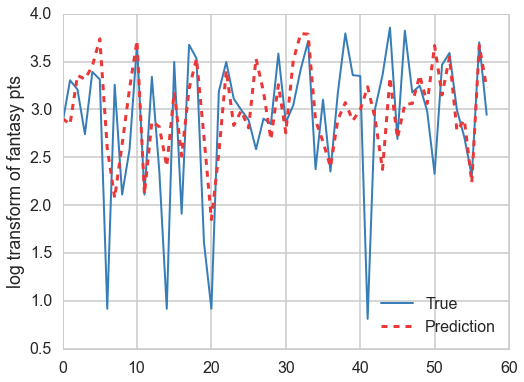

In [1422]:
plt.figure(figsize=(8,6))
plt.plot(results['FANTASY_PTS_RESP'], label='True', color='#377EB8', linewidth=2)
plt.plot(results['PREDFANTASY_PTS'], 
     '--', color='#EB3737', linewidth=3, label='Prediction')
plt.legend(loc='lower right')
plt.ylabel('log transform of fantasy pts')
plt.show()

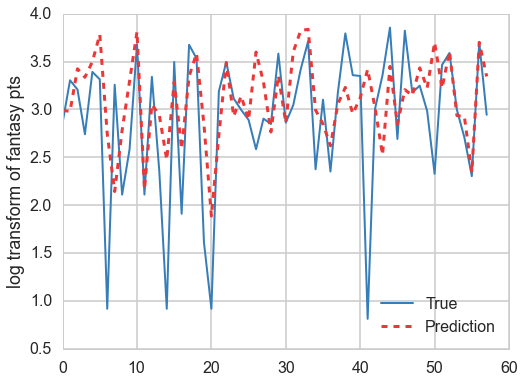

In [1446]:
plt.figure(figsize=(8,6))
plt.plot(results['FANTASY_PTS_RESP'], label='True', color='#377EB8', linewidth=2)
plt.plot(results['PREDFANTASY_PTS'], 
     '--', color='#EB3737', linewidth=3, label='Prediction')
plt.legend(loc='lower right')
plt.ylabel('log transform of fantasy pts')
plt.show()

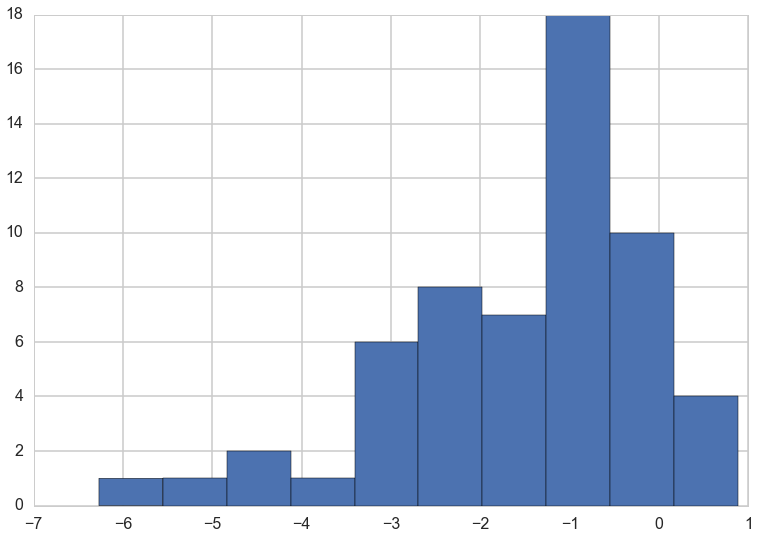

In [1439]:
np.log(results.apply(lambda x: abs(x.FANTASY_PTS_RESP - x.PREDFANTASY_PTS), axis = 1).sort_values(ascending = False)).hist()